In [ ]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [ ]:
randomState = 42
np.random.seed(randomState)
tf.set_random_seed(randomState)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
raw10 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_10.csv')
df10 = raw10.copy()

df10 = df10.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df10['NDVI'])
replace_missing(df10['EVI'])
replace_missing(df10['LSTDay'])
replace_missing(df10['LSTNight'])

df10 = df10.dropna()
df10.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [ ]:
df10['group'] = df10['Sand'].ne(df10['Sand'].shift()).cumsum()
df10 = df10.groupby('group')
dfs = []
for name, data in df10:
    dfs.append(data)

In [ ]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [ ]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [ ]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [ ]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys= [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 15

x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)

In [ ]:
dim_learning_rate = Real(low=1e-5, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_layers = Integer(low=2, high=3, name='num_layers')
dim_num_nodes = Integer(low=128, high=512, name='num_nodes')
dim_dropout_val = Real(low=0.10, high=0.25, name='dropout_val')

dimensions = [dim_learning_rate,
              dim_num_layers,
              dim_num_nodes,
              dim_dropout_val]

default_parameters = [1e-3, 2, 256, 0.2]

In [ ]:
# To log traning progress
def log_dir_name(learning_rate, num_layers, num_nodes, dropout_val):
    # dir-name for TensorBoard log-dir.
    s = "/content/gdrive/MyDrive/SoilMoisture/LSTMlogs/lr_{0:.0e}_layers_{1}_nodes_{2}_dropout_{3}"
    log_dir = s.format(learning_rate, num_layers, num_nodes, dropout_val)

    return log_dir

In [ ]:
#To create model with determined hyperparameters
def create_model(learning_rate, num_layers, num_nodes, dropout_val):
    model = Sequential()
    model.add(InputLayer(input_shape=(None, 13)))
    for i in range(num_layers-1):
        name = 'layer_LSTM_{0}'.format(i+1)
        model.add(LSTM(units=num_nodes, return_sequences=True, activation='tanh', name=name))
        model.add(Dropout(dropout_val))
    model.add(LSTM(units=num_nodes, activation='tanh'))
    model.add(Dropout(dropout_val))
    model.add(Dense(units=1))
    # Adam Optimizer
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

path_best_model = '/content/gdrive/MyDrive/SoilMoisture/LSTM_Models/LSTM_10_best_model.h5'
validation_data = (x_val, y_val)
best_loss = 5.0

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_layers, num_nodes, dropout_val):
    """
    Hyper-parameters:
    learning_rate: Learning-rate for the optimizer.
    num_layers:    Number of LSTM layers.
    num_nodes:     Number of nodes in each LSTM layer.
    dropout_val:   Dropout.
    """
    # Print the hyper-parameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_LSTM_layers:', num_layers)
    print('num_LSTM_nodes:', num_nodes)
    print('dropout:', dropout_val)
    print()    
    # Create the LSTM
    model = create_model(learning_rate=learning_rate,
                         num_layers=num_layers,
                         num_nodes=num_nodes,
                         dropout_val=dropout_val)
    # Dir-name for TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_layers, num_nodes, dropout_val)
    #callback
    callback_log = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
    # Use Keras to train the model.
    history = model.fit(x= x_train,
                        y= y_train,
                        epochs=30,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    loss = history.history['val_loss'][-1]

    print()
    print("MSE Loss:", loss)
    print()

    global best_loss

    if loss < best_loss:
        # Save the new model
        model.save(path_best_model)
        best_loss = loss

    del model
    
    K.clear_session()
    
    return loss

In [ ]:
start = time.time()
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',          # Expected Improvement.
                            n_calls=25,
                            x0=default_parameters)
print("Optimization Run Time: ", (time.time()-start)/60)

learning rate: 1.0e-03
num_LSTM_layers: 2
num_LSTM_nodes: 256
dropout: 0.2

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43082 samples, validate on 5368 samples
Epoch 1/30
43082/43082 [==============================] - 10s 241us/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 2/30
43082/43082 [==============================] - 10s 222us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 3/30
43082/43082 [==============================] - 10s 232us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 4/30
43082/43082 [==============================] - 10s 235us/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 5/30
43082

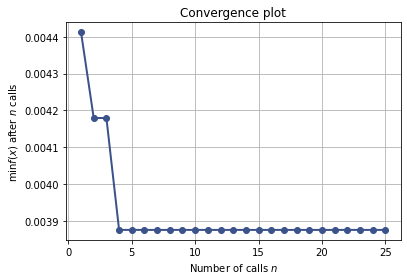

In [ ]:
plot_convergence(search_result) 

In [ ]:
#best hyperparameters
print("Best Hyperparameters: ",search_result.x)

#corr. result
print(search_result.fun)

Best Hyperparameters:  [0.00010807369623756937, 3, 228, 0.1796937072257201]
0.0038754417246621205


In [ ]:
#All Results
sorted(zip(search_result.func_vals, search_result.x_iters))

[(0.0038754417246621205, [0.00010807369623756937, 3, 228, 0.1796937072257201]),
 (0.00405477549625358, [0.007438446837196045, 2, 140, 0.10027594107397321]),
 (0.0041186065737840935, [0.002051879305820228, 2, 267, 0.23663504848962558]),
 (0.004142290447601263, [0.0009799579487643013, 3, 249, 0.11486206615446815]),
 (0.004179203018807041, [0.0008149611716055347, 3, 372, 0.14046559148152127]),
 (0.004188697507546663, [0.0003034817580684375, 3, 392, 0.1702891410195242]),
 (0.004206115107541979, [0.001526098423429937, 2, 292, 0.2448672338184362]),
 (0.004246444761997364, [4.7889870101177694e-05, 2, 382, 0.16365584941648176]),
 (0.004272948969960568, [0.008466243006211424, 3, 143, 0.24878002799299176]),
 (0.004294327596596674, [0.006128579897980079, 3, 222, 0.1940168343281198]),
 (0.004307983696444069, [1.0239492325329972e-05, 3, 507, 0.10039943248803135]),
 (0.004338106528429756, [0.002953493640253192, 2, 322, 0.22794152975808044]),
 (0.004412043684588304, [0.001, 2, 256, 0.2]),
 (0.0044471

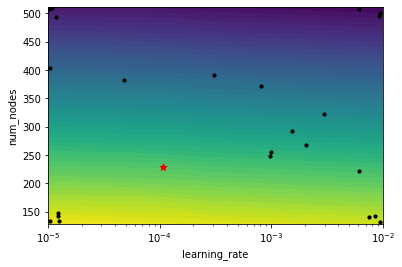

In [ ]:
from skopt.plots import plot_objective_2D
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_nodes',
                        levels=50)

ValueError: ignored

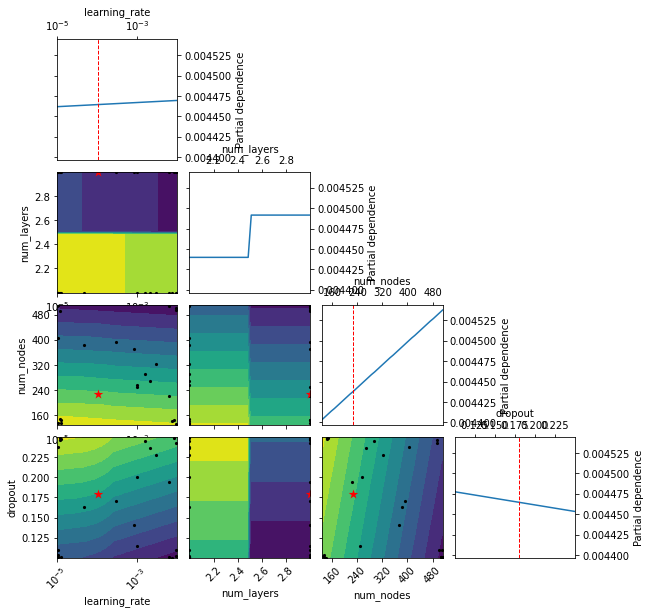

In [ ]:
# create a list for plotting
dim_names = ['learning_rate', 'num_layers', 'num_nodes', 'dropout' ]

fig, ax = plot_objective(result=search_result, dimensions=dim_names)

In [ ]:
best_model= load_model(path_best_model)

AttributeError: ignored

In [ ]:
opt_par = [1.244972586024732e-05, 2, 134, 0.2]

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_layers = opt_par[1]
num_nodes = opt_par[2]
dropout_value = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(None, 13)))
for i in range(num_layers-1):
    name = 'layer_LSTM_{0}'.format(i+1)
    model.add(LSTM(units=num_nodes, return_sequences=True, activation='tanh', name=name))
    model.add(Dropout(dropout_value))
model.add(LSTM(units=num_nodes, activation='tanh'))
model.add(Dropout(dropout_value))
model.add(Dense(units=1))
optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_LSTM_1 (LSTM)          (None, None, 134)         79328     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 134)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 134)               144184    
_________________________________________________________________
dropout_6 (Dropout)          (None, 134)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 135       
Total params: 223,647
Trainable params: 223,647
Non-trainable params: 0
_________________________________________________________________
Train on 43082 samples, validate on 5368 samples
Epoch 1/100
43082/43082 - 40s - loss: 0.0126 - mean_squared_error

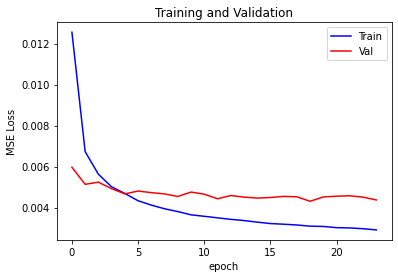

In [ ]:
plt.plot(histories.history['loss'], 'b')
plt.plot(histories.history['val_loss'],'r' )
plt.title('Training and Validation')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/LSTM_Images/MSE_c5_10.png', dpi=400)
plt.show()